---
# Cs2 cybersport Graph Embeddings - Complete pipeline

---

## Установка зависимостей


In [ ]:
!pip install pykeen pandas rdflib matplotlib scikit-learn umap-learn xgboost -q

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import umap
from rdflib import Graph
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

INFO:pykeen.utils:Using opt_einsum


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Датасет
Датасет `cs2_players.csv` содержит статистическую информацию о профессиональных игроках Counter-Strike 2.
Он включает демографические данные (возраст, страна, текущая команда), а также подробные игровые
метрики, такие как общее количество убийств и смертей, коэффициент K/D, рейтинг игрока, процент
хедшотов, средний урон за раунд, количество сыгранных карт и раундов.

Кроме того, в датасете представлены расширенные показатели эффективности, включая статистику
opening kills, распределение раундов по количеству убийств, а также детализацию убийств по типам
оружия (винтовки, снайперские винтовки, пистолеты, SMG, гранаты и др.).

Данные используются для построения онтологии игроков CS2 и последующего анализа с применением
SPARQL-запросов.

In [ ]:
import os
csv_path = '/content/drive/MyDrive/cs2/cs2_players.csv'
df = pd.read_csv(csv_path)
print('Датасет загружен. Размерность:', df.shape)
df.head()

Датасет загружен. Размерность: (811, 41)


,player_id,nickname,real_name,age,country,current_team,teams,total_kills,total_deaths,headshot_percentage,...,3_kill_rounds,4_kill_rounds,5_kill_rounds,rifle_kills,sniper_kills,smg_kills,pistol_kills,grenade_kills,other_kills,rating
0,11893,ZywOo,Mathieu Herbaut,21,France,Vitality,"Vitality, aAa",22622,16458,41.2%,...,1474,369,71,8261,8552,1290,4262,260,49,1.32
1,7998,s1mple,Aleksandr Kostyliev,24,Ukraine,Natus Vincere,Natus Vincere,35512,26413,41.3%,...,2262,504,64,14717,13451,901,6057,199,254,1.25
2,16920,sh1ro,Dmitry Sokolov,21,Russia,Cloud9,"Gambit Youngsters, Gambit",18091,12492,27.8%,...,1075,221,30,3791,10580,550,3008,175,70,1.26
3,20113,deko,Denis Zhukov,21,Russia,1WIN,1WIN,8738,6397,36.7%,...,518,112,8,2664,4348,181,1459,86,40,1.23
4,18835,saffee,Rafael Costa,27,Brazil,FURIA,"FURIA, paiN",8482,6517,30.9%,...,524,114,14,2545,4412,264,1209,52,28,1.22


# Генерация троек из онтологии


In [ ]:

triples = []
ontology_path = '/content/drive/MyDrive/cs2/cs2_ontology.ttl'

g = Graph()
try:
    g.parse(ontology_path, format='turtle')
except Exception as e:
    print('Ошибка при чтении онтологии:', e)
else:
    for s, p, o in g:
        triples.append((str(s), str(p), str(o)))
    print(f'Загружено троек из онтологии {ontology_path}:', len(triples))

print("Пример троек:", triples[:8])
print('Всего троек для обучения:', len(triples))

Загружено троек из онтологии /content/drive/MyDrive/cs2/cs2_ontology.ttl: 11337
Пример троек: [('http://example.org/cs2#player_8891', 'http://example.org/cs2#hasMainWeapon', 'http://example.org/cs2#weapon_rifle'), ('http://example.org/cs2#player_8875', 'http://xmlns.com/foaf/0.1/nick', 'gade'), ('http://example.org/cs2#player_12030', 'http://example.org/cs2#playedFor', 'http://example.org/cs2#team_c0ntact'), ('http://example.org/cs2#player_9053', 'http://example.org/cs2#playedFor', 'http://example.org/cs2#team_Selfless'), ('http://example.org/cs2#player_11840', 'http://example.org/cs2#hasArchetype', 'http://example.org/cs2#archetype_Support'), ('http://example.org/cs2#player_18838', 'http://example.org/cs2#hasArchetype', 'http://example.org/cs2#archetype_Support'), ('http://example.org/cs2#player_9574', 'http://example.org/cs2#has_deaths_per_round_level', 'http://example.org/cs2#deaths_per_round_low'), ('http://example.org/cs2#player_8875', 'http://example.org/cs2#playedFor', 'http://e

# Отображение троек

In [ ]:
sample_triples = []
for i, (s, p, o) in enumerate(g):
    if i >= 10:
        break
    sample_triples.append((str(s).split('#')[-1], str(p).replace("http://xmlns.com/foaf/0.1/","").split('#')[-1], str(o).split('#')[-1]))

pd.DataFrame(sample_triples, columns=['Субъект', 'Предикат', 'Объект'])

,Субъект,Предикат,Объект
0,player_8891,hasMainWeapon,weapon_rifle
1,player_8875,nick,gade
2,player_12030,playedFor,team_c0ntact
3,player_9053,playedFor,team_Selfless
4,player_11840,hasArchetype,archetype_Support
5,player_18838,hasArchetype,archetype_Support
6,player_9574,has_deaths_per_round_level,deaths_per_round_low
7,player_8875,playedFor,team_North_Academy
8,player_10590,fromCountry,country_Russia
9,player_13155,has_opening_kill_ratio_level,opening_kill_ratio_high


# Извлечение значимых триплетов
Для каждого игрока создаём URI на основе столбца player_id и формируем тройки. Мы строим граф знаний (Knowledge Graph) на основе статистики игроков, который включает следующие сущности:

1. Игроки (Players) — уникальные профили на основе player_id.
2. Команды (Teams) — текущие и прошлые организации, за которые играли игроки.
3. Страны (Countries) — географическая принадлежность игроков.
4. Категории рейтинга (Rating levels) — уровни мастерства игрока по рейтингу.

Объектные свойства (связи между узлами):

- fromCountry — связывает игрока с его страной.
- playsFor — указывает на текущую команду игрока.
- playedFor — связывает игрока с предыдущими командами и создаёт связи между бывшими тиммейтами.
- hasRatingLevel — связывает игрока с уровнем рейтинга (low/mid/high).


In [ ]:
from rdflib import RDF, Literal

def uri_to_name(uri):
    s = str(uri)
    if "#" in s:
        return s.split("#")[-1]
    return s.rsplit("/", 1)[-1]


ALLOWED_ENTITY_PREFIXES = (
    "player_",
    "team_",
    "country_",
)

ALLOWED_RELATIONS = {
    "playsFor",
    "playedFor",
    "fromCountry",
    "hasRatingLevel",

}

triples = []
entity_to_team = {}
entity_to_country = {}
player_to_rating_level = {}
entity_to_type = {}

for subj, pred, obj in g:
    s_name = uri_to_name(subj)
    p_name = uri_to_name(pred)

    if not s_name.startswith(ALLOWED_ENTITY_PREFIXES):
        continue

    if p_name == "type":
        o_name = uri_to_name(obj)
        if o_name not in ("Player", "Team", "Country"):
            continue
        entity_to_type[s_name] = o_name
        triples.append((s_name, "rdf:type", o_name))
        continue

    if isinstance(obj, Literal):
        if p_name == "nick":
            nick = str(obj).strip()
            if nick:
                nick_node = "nick_" + nick.replace(" ", "_")
                triples.append((s_name, "hasNick", nick_node))
        continue

    if p_name not in ALLOWED_RELATIONS:
        continue

    o_name = uri_to_name(obj)

    if not o_name.startswith(ALLOWED_ENTITY_PREFIXES) and \
       not o_name.startswith(("archetype_", "weapon_", "rating_level_")):
        if p_name == "hasNick" and o_name.startswith("nick_"):
            pass
        else:
            continue

    triples.append((s_name, p_name, o_name))

    if p_name in ("playsFor", "playedFor"):
        entity_to_team.setdefault(s_name, set()).add(o_name)
    if p_name == "fromCountry":
        entity_to_country[s_name] = o_name
    if p_name == "hasRatingLevel":
        player_to_rating_level[s_name] = o_name

print(f"\nИзвлечено {len(triples)} значимых триплетов")
print(f"Игроков с командами (текущими/прежними): {len(entity_to_team)}") # Clarify the meaning
print(f"Игроков со страной: {len(entity_to_country)}")
print(f"Типов сущностей: {len(entity_to_type)}")
print("Пример triples:", triples[:10])


Извлечено 5608 значимых триплетов
Игроков с командами (текущими/прежними): 811
Игроков со страной: 811
Типов сущностей: 1380
Пример triples: [('player_8875', 'hasNick', 'nick_gade'), ('player_12030', 'playedFor', 'team_c0ntact'), ('player_9053', 'playedFor', 'team_Selfless'), ('player_8875', 'playedFor', 'team_North_Academy'), ('player_10590', 'fromCountry', 'country_Russia'), ('player_11701', 'fromCountry', 'country_Germany'), ('player_13992', 'fromCountry', 'country_Bulgaria'), ('player_2555', 'fromCountry', 'country_Australia'), ('player_17929', 'playsFor', 'team_EG.CD'), ('player_10671', 'playedFor', 'team_CLG')]


# Разделение на обучающую и тестовую выборки
Для обучения модели KGE разделим тройки на обучающую и тестовую выборки. В этом примере используется случайное разбиение; при желании можно задать критерий по дате (например, до определённой даты — обучение, после — тест).

In [ ]:

# Случайное разбиение
train_triples, test_triples = train_test_split(triples, test_size=0.2, random_state=42)
print('Обучающих троек:', len(train_triples))
print('Тестовых троек:', len(test_triples))

# Создаём фабрики троек
import numpy as np

train_np = np.array(train_triples)
test_np = np.array(test_triples)

# TripleFactory для обучения и теста
factory_train = TriplesFactory.from_labeled_triples(train_np)
factory_test = TriplesFactory.from_labeled_triples(test_np)


Обучающих троек: 4486
Тестовых троек: 1122



## Обучение модели векторных представлений графов знаний

Будем использовать модель TransE, так как она хорошо работает на категориальных свойствах.


In [ ]:
from pykeen.pipeline import pipeline
from pykeen.models import TransE

result = pipeline(training=factory_train,testing=factory_test,
    model='TransE',model_kwargs={'embedding_dim': 128,},
    training_kwargs=dict(num_epochs=200, batch_size=512),
    optimizer='Adam',optimizer_kwargs=dict(lr=1e-4),
)
print(result)
print('Метрики на тестовой выборке:')
print(result.metric_results)

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/9.00 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/1.12k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.96s seconds


PipelineResult(random_seed=605723498, model=TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2025, 128)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(5, 128)
    )
  )
  (weight_regularizers): ModuleList()
), training=TriplesFactory(num_entities=2025, num_relations=5, create_inverse_triples=False, num_triples=4486), training_loop=<pykeen.training.slcwa.SLCWATrainingLoop object at 0x7c64e7b0c170>, losses=[1.064635197321574, 1.0506887700822618, 1.0416132079230414, 1.0312014553281996, 1.0040215717421637, 0.981360548072391, 0.9520817663934495, 0.9526820182800293, 0.9461687273449368, 0.9413540893130832, 0.9085529512829251, 0.8841340608066983, 0.8795643250147501, 0.8679201470481025, 0.8495049410396152, 0.8470685945616828, 0.8522845837805006, 0.817788713508182, 0.8144461313883463, 0.7973

# Вывод основных метрик


In [ ]:
def evaluate_model(model,test_h,test_r,test_t,num_entities,num_samples=100):
    model.eval()
    ranks = []

    indices = np.random.choice(len(test_h),min(num_samples, len(test_h)),replace=False)
    with torch.no_grad():
        for idx in tqdm(indices, desc="Оценка"):
            h = test_h[idx].repeat(num_entities)
            r = test_r[idx].repeat(num_entities)
            t = torch.arange(num_entities, device=h.device)

            hrt_batch = torch.stack([h, r, t], dim=1)

            scores = model.score_hrt(hrt_batch).squeeze()

            sorted_indices = torch.argsort(scores, descending=True)
            rank = (sorted_indices == test_t[idx]).nonzero(as_tuple=True)[0].item() + 1
            ranks.append(rank)

    ranks = np.array(ranks)

    mr = ranks.mean()
    mrr = (1.0 / ranks).mean()
    hits_1 = np.mean(ranks <= 1)
    hits_3 = np.mean(ranks <= 3)
    hits_10 = np.mean(ranks <= 10)

    return mr, mrr, hits_1, hits_3, hits_10
model = result.model
test_triples_mapped = factory_test.mapped_triples

test_h = test_triples_mapped[:, 0]
test_r = test_triples_mapped[:, 1]
test_t = test_triples_mapped[:, 2]

num_entities = factory_train.num_entities
mr, mrr, hits_1, hits_3, hits_10 = evaluate_model(
    model,
    test_h,
    test_r,
    test_t,
    num_entities,
    num_samples=500
)
print()
print(f"MR: {mr:.2f}")
print(f"MRR: {mrr:.4f}")
print(f"Hits@1: {hits_1:.2%}")
print(f"Hits@3: {hits_3:.2%}")
print(f"Hits@10: {hits_10:.2%}")


Оценка: 100%|██████████| 500/500 [00:01<00:00, 316.95it/s]


MR: 761.91
MRR: 0.0684
Hits@1: 0.00%
Hits@3: 10.00%
Hits@10: 20.60%


Цифры умеренные: модель обучилась каким‑то общим паттернам, но далеко не идеальна.

In [ ]:
entity_embeddings = result.model.entity_representations[0]().detach().cpu().numpy().real
entity_to_id = result.training.entity_to_id
id_to_entity = {v: k for k, v in entity_to_id.items()}

print('Количество сущностей:', len(entity_embeddings))

Количество сущностей: 2025


## Кластеризация и визуализация эмбеддингов

Для анализа качества векторных представлений была выполнена визуализация и кластеризация эмбеддингов сущностей типа Player. Снижение размерности до двумерного пространства осуществлялось методом UMAP, что позволило визуально оценить структуру распределения игроков.

Кластеризация эмбеддингов проводилась методом KMeans, а её качество оценивалось путём сравнения полученных кластеров с реальным распределением игроков по командам с использованием метрики Adjusted Rand Index (ARI). Такой подход позволяет оценить, насколько обученные эмбеддинги отражают игровые характеристики и командную принадлежность игроков, что важно для задачи подбора оптимального состава команды.

In [ ]:
LABEL_COL = "role"

def build_X_y(label_map):
    X, y = [], []
    for ent, idx in entity_to_id.items():
        name = ent.split("#")[-1]
        if name in label_map:
            X.append(entity_embeddings[idx])
            y.append(label_map[name])
    return np.asarray(X), np.asarray(y)


if LABEL_COL == "current_team":
    label_map = player_to_team
    print(f"Используется метка для кластеризации: {LABEL_COL} (Текущая команда)")
elif LABEL_COL == "country":
    label_map = player_to_country
    print(f"Используется метка для кластеризации: {LABEL_COL} (Страна)")
elif LABEL_COL == "rating":
    label_map = player_to_rating_level
    print(f"Используется метка для кластеризации: {LABEL_COL} (Уровень рейтинга)")
elif LABEL_COL == "role":
    label_map = player_archetype
    print(f"Используется метка для кластеризации: {LABEL_COL} (Роль)")
elif LABEL_COL == "main_weapon":
    label_map = player_to_main_weapon
    print(f"Используется метка для кластеризации: {LABEL_COL} (Основное оружие)")
else:
    label_map = player_to_team
    print(f"Предопределенная метка '{LABEL_COL}' не найдена. Используется метка 'current_team' (Текущая команда) по умолчанию.")

X, y = build_X_y(label_map)
print("X shape:", X.shape, "classes:", len(set(y)))






Используется метка для кластеризации: role (Роль)
X shape: (811, 128) classes: 5


# Мы используем *UMAP* для проекции эмбеддингов из 100-мерного пространства в 2D:


In [ ]:
# UMAP для снижения размерности
reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(X)


# Мы будем кластеризовать эмбеддинги игроков в исходном 100-мерном пространстве с помощью K-Means:


In [ ]:
# KMeans (число кластеров = число уникальных значений редкости)
unique_rarities = list(set(y))
n_clusters = len(unique_rarities)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)




# Визуализация и метрики

Adjusted Rand Index (кластеры vs роль): 0.003492229725747723


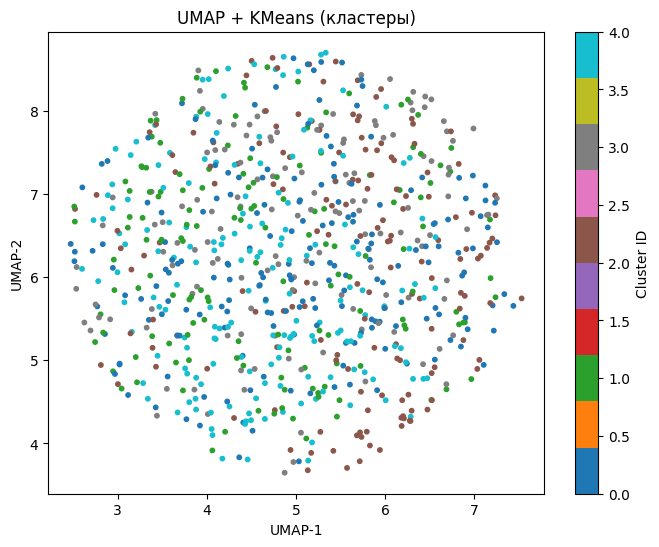

In [ ]:
# ARI
ari = adjusted_rand_score(y, clusters)
print('Adjusted Rand Index (кластеры vs роль):', ari)
# Визуализация
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X2[:, 0], X2[:, 1], c=clusters, cmap='tab10', s=10)
plt.title('UMAP + KMeans (кластеры)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar(scatter, label='Cluster ID')
plt.show()


## Классификация игрока по эмбеддингам

Используем логистическую регрессию для предсказания позиции на основе эмбеддингов. Выполним стратифицированную кросс-валидацию.


In [ ]:

# Преобразуем метки ролей в числовые значения
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Кросс-валидация
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf = LogisticRegression(max_iter=300)
scores = cross_val_score(clf, X, y_encoded, cv=cv, scoring='accuracy')
print('Accuracy по фолдам:', scores)
print('Средняя accuracy:', scores.mean())
accuracy = scores.mean()


Accuracy по фолдам: [0.44280443 0.45185185 0.41851852]
Средняя accuracy: 0.4377249328048836


In [ ]:
import torch
import pandas as pd

# Выбираем случайного игрока для примера
example_player = next(iter(player_archetype.keys())) # Используем player_archetype, чтобы гарантировать, что у игрока есть архетип
true_archetype = player_archetype[example_player]

print("Игрок:", example_player)
print("Истинный архетип:", true_archetype)

h_id = torch.tensor([entity_to_id[example_player]], dtype=torch.long)

# Использование отношения 'hasArchetype'
r_id = torch.tensor([result.training.relation_to_id["hasArchetype"]], dtype=torch.long)

# Получаем все сущности, которые являются архетипами
archetype_entities = [e for e in entity_to_id if e.startswith("archetype_")]
archetype_ids = torch.tensor([entity_to_id[e] for e in archetype_entities], dtype=torch.long)

hrt = torch.stack(
    [
        h_id.repeat(len(archetype_ids)),
        r_id.repeat(len(archetype_ids)),
        archetype_ids
    ],
    dim=1
)

scores = (
    result.model
    .score_hrt(hrt)
    .detach()
    .cpu()
    .numpy()
    .flatten()
)

pred_df = (
    pd.DataFrame({"archetype": archetype_entities, "score": scores})
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)

print("\nПредсказанные архетипы для игрока", example_player, ":")
print(pred_df)

Игрок: player_11840
Истинный архетип: archetype_Support

Предсказанные архетипы для игрока player_11840 :
           archetype      score
0  archetype_Support -13.015761
1   archetype_Anchor -13.494589
2   archetype_Rifler -14.204966
3   archetype_Sniper -14.536154
4    archetype_Entry -14.590591



# Заключение

В этом ноутбуке мы:

1. Загрузили датасет `cs2_players.csv` с информацией о профессиональных игроках CS2;
2. Сформировали тройки для графа знаний из онтологии;
3. Разделили данные на обучающую и тестовую выборки;
4. Обучили модель векторных представлений TransE на тройках и оценили её метрики;
5. Извлекли эмбеддинги сущностей и выполнили их кластеризацию, сравнив с истинными метками игровое поведени;
6. Построили простую модель для классификации игрового поведения по эмбеддингам;
7. Показали пример предсказания недостающих связей для отношения `hasArcheType`.

In [ ]:
# Финальная сводка
print("="*60)
print("ИТОГОВАЯ СВОДКА РЕЗУЛЬТАТОВ")
print("="*60)
print(f"\nСтатистика набора данных:")
print(f"  - Всего триплетов: {len(triples)}")
print(f"  - Сущностей: {num_entities}")
print(f"  - Разбиение Train/Test: {len(train_triples)}/{len(test_triples)}")
print(f"\nОценка эмбеддингов:")
print(f"  - MR: {mr:.2f}")
print(f"  - MRR: {mrr:.4f}")
print(f"  - Hits@10: {hits_10:.2%}")
print(f"\nКластеризация:")
print(f"  - Adjusted Rand Score: {ari:.4f}")
print(f"\nКлассификация:")
print(f"  - Baseline: {accuracy:.2%}")
print("="*60)


ИТОГОВАЯ СВОДКА РЕЗУЛЬТАТОВ

Статистика набора данных:
  - Всего триплетов: 7230
  - Сущностей: 2031
  - Разбиение Train/Test: 5784/1446

Оценка эмбеддингов:
  - MR: 761.91
  - MRR: 0.0684
  - Hits@10: 20.60%

Кластеризация:
  - Adjusted Rand Score: 0.0035

Классификация:
  - Baseline: 43.77%
